## hm4di vs mcherry

### Load Files and Format Data

In [11]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as bp
import seaborn as sns
import statsmodels.api as sm
import scipy.stats

In [12]:
def timefromfile(filename):
    "Convert filename to timestamp for start of trials"
    datetime = re.findall("\d\d_\d\d_\d\d_T_\d\d_\d\d_\d\d", filename)[0]
    datetime = datetime.replace("_", "-", 2).replace("_T_", " ").replace("_", ":")
    return pd.Timestamp(datetime)

In [13]:
def loadfile(filename):
    '''Given a string filename, loads in the data, extracts the start time from the filename, and formats the timestamps based on the start time.'''
    animal = pd.read_csv(filename, header=None)
    animal = animal.rename(columns={0:"timestamp",1:"poke", 2:"lick", 3:"water", 4:"delay"})
    datetime = timefromfile(filename)
    animal["timestamp"] = pd.to_datetime(animal["timestamp"], unit="s", origin=pd.Timestamp(datetime))
    animal["delay"] = pd.to_timedelta(animal["delay"], unit="ms")
    return animal.iloc[:, 0:5]

In [14]:
def getTrials (tp):
    (idx, x) = tp
    return pd.Series([idx for i in range(x)], dtype="int")

In [15]:
def labelTrials (animal):
    '''Given the set of data for an animal, labels each sample in a trial with the trial type and the trial number, numbering trials consecutively from 1.
    The number of trials, and the number of each trial type, matches v16 of the matlab analysis.
    '''
    #first sample for each new trial - current water code is not 7 (timeout) and previous is 7 plus first and last sample (for diff alignment)
    trial_boundaries = pd.concat([animal.iloc[[0]], animal[(animal["water"]!=7) & (animal["water"].shift() == 7)], animal.iloc[[animal.shape[0]-1]]])

    trial_count = pd.Series(trial_boundaries.index)    
    #get number of samples per trial (difference in sample number between previous boundary and current boundary)
    trial_count = pd.Series(enumerate(trial_count.diff().fillna(0).astype('int').tolist()))
    #enumerate trial number from first sample to all samples in trial
    trial_count = trial_count.map(getTrials).explode()[1:]
    trial_count.index = range(0, trial_count.shape[0])
    animal.insert(1, "trial no", trial_count)
    #set trial no for last sample
    animal.loc[animal.shape[0] - 1, "trial no",] = trial_boundaries.shape[0] -1

    #label trial types
    go = animal.groupby(["trial no"]).filter(lambda x: (x["water"]==3).any())
    go["trial type"] = ["water" for i in range(go.shape[0])]
    animal["trial type"] = go["trial type"]
    animal["trial type"] = animal["trial type"].fillna(value="blank")

    return animal

In [16]:
def init_data(data, animal, cond):
    '''Set animal and condition and update lick value to binary 1/0'''
    data.loc[data["lick"] == 2,"lick"] = 1
    data["animal"] = animal
    data["condition"] = cond
    #print(data)
    return data

In [17]:
def load_sat(pSAT, animals, name, metadata):
    for d in os.listdir(pSAT):
        p = pSAT + "\\" + d
        #guarantees files opened in time order (path list is arbitrary)
        fs = os.listdir(p)
        fs.sort()
        curranimal = []
        print(d)
        for f in fs:
            if (os.path.isfile(p + "\\" + f)):      
                curranimal.append(loadfile(p + "\\" + f))
        #all files concatenated in order
        curranimal = labelTrials(pd.concat(curranimal, ignore_index=True))
        if (metadata[metadata["Animal ID"] == d].empty):
            curranimal["acc"] = pd.to_timedelta(1, unit="D")
        else:
            acc_days = metadata[metadata["Animal ID"] == d].reset_index()["Acclimation (days)"][0]
            if d == "NDR1":
                acc_days = acc_days + 1
            curranimal["acc"] = pd.to_timedelta(acc_days, unit="D")            
        curranimal = init_data(curranimal, d, name)
        #print(curranimal)
        animals = pd.concat([animals, curranimal])
    return animals


In [18]:
def load_100(animals, path_100_80):
    #100 80 SAT directory
    for d in os.listdir(path_100_80):
        p = path_100_80 + "\\" + d
        #animal directory (path list is arbitrary)
        andirs = os.listdir(p)
        andirs = sorted(andirs, key=str.lower)
        curranimal = []
        print(d)
        for d2 in andirs:
            p2 = p + "\\" + d2
            #acc/SAT - sort if multiple files
            fs = os.listdir(p2)
            fs.sort()  
            for f in fs:            
                if os.path.isfile(p2 + "\\" + f):
                    curranimal.append(loadfile(p2 + "\\" + f))
        #all files concatenated in order   
        curranimal = labelTrials(pd.concat(curranimal, ignore_index=True))
        curranimal["acc"] = pd.to_timedelta(1, unit="D")
        curranimal = init_data(curranimal, d, "SAT_100_80")
        
        animals = pd.concat([animals, curranimal])
    return animals


In [19]:
def load_all_data(SATpaths, path_100_80, metadata):
    animals = pd.DataFrame()
    
    for (pSAT, name) in SATpaths:
        print(name)
        animals = pd.concat([animals, load_sat(pSAT, pd.DataFrame(), name, metadata)])
    animals = pd.concat([animals, load_100(pd.DataFrame(), path_100_80)])
    
    animals = animals.set_index(["condition", "animal", "trial no"])

    return animals

In [20]:
#load all data - 100, 80, hM4di, mcherry

#load metadata
path_metadata = "C:\\Users\\swind\\Documents\\lab work\\lab work barth\\behavior analysis\\Eunsol data\\Animal lists.xlsx"
hm4di_metadata = pd.read_excel(path_metadata)
hm4di_metadata[hm4di_metadata["Animal ID"] == "MJn3"]["Acclimation (days)"]

#load data for prelim animals
prelim_path_SAT = "C:\\Users\\swind\\Documents\\lab work\\lab work barth\\behavior analysis\\Eunsol data\\prelim\\SAT"
prelim_path_100_80 = "C:\\Users\\swind\\Documents\\lab work\\lab work barth\\behavior analysis\\Eunsol data\\prelim\\100 80 SAT"
prelim = load_all_data([(prelim_path_SAT, "SAT")], prelim_path_100_80, hm4di_metadata)

#load data for all animals
all_SAT = "C:\\Users\\swind\\Documents\\lab work\\lab work barth\\behavior analysis\\Eunsol data\\all animals\\SAT"
all_100_80 = "C:\\Users\\swind\\Documents\\lab work\\lab work barth\\behavior analysis\\Eunsol data\\all animals\\100 80"
all_mch = "C:\\Users\\swind\\Documents\\lab work\\lab work barth\\behavior analysis\\Eunsol data\\all animals\\mcherry"
all_hm4di = "C:\\Users\\swind\\Documents\\lab work\\lab work barth\\behavior analysis\\Eunsol data\\all animals\\hM4Di SAT"
all_animals = load_all_data([(all_SAT, "SAT"), (all_mch, "mcherry"), (all_hm4di, "hm4di")], all_100_80, hm4di_metadata)

SAT
GSB8 Caitlyn
GXS5 True
JSS4
NJO1
NLB10
NLB8
NLG3
NLN3
SAT
GKO6 Mason
GSB8 Caitlyn
GXC7 Bambi
GXS4 Khloe
GXS5 True
JND2
JOV1
JSS4
NFZ13
NFZ4
NGX5
NJO1
mcherry
MJL2
MJN2
MJN3
MJN5
MYC4
MZG4
MZG5
NBE11
NCY1
NCY4
NCY6
NDR1
NIO15
NIO16
hm4di
LWP2
LWP4
LWP6
LWP8
MKV10
MKV11
MKV14
NAS9
NBX7
NBX9
NEJ1
NJW5
NKZ10
NKZ3
NKZ4
NKZ7
NLB1
NLB10
NLB3
NLB8
NLG3
NLN3
NLN5
NLV2
NLV3
NLV5


### Functions for analysis

In [21]:
def delta(data, key):
    '''calculates time since start of SAT. key is column to use to calculate'''
    data = data.set_index(["condition", "animal", "trial no"])
    delta = data[key] - data.sort_values(key).groupby("animal")[key].first() - data.groupby("animal")["acc"].first()
    data["delta"] = delta#.astype("timedelta64[m]")
    return data.reset_index()

In [22]:
def deliverydelta(data):
    #find start of air delivery (trial start + delay to puff)
    data = data.set_index(["condition", "animal", "trial no"])
    grouped = data.groupby(["condition", "animal", "trial no"])
    data["air start"] = grouped["timestamp"].first() + grouped["delay"].first() #+ pd.to_timedelta("1s")
    data["delivery delta"]  = data["timestamp"] - data["air start"]
    data = data.drop(columns="air start")
    return data.reset_index()

In [23]:
def trialdelta(data):
    trials = data.groupby(["animal", "trial no"]).first().reset_index().set_index("animal")["trial no"]
    start = pd.to_timedelta(0, unit="ms")
    td = (trials - data[(data["delta"] >= start)].groupby("animal")["trial no"].first()).rename("trial delta")
    td = pd.concat([trials, td], axis=1).set_index("trial no", append=True)
    data = data.set_index(["animal", "trial no"])
    data["trial delta"] = td
    return data.reset_index()

In [24]:
def freqCurve(data, freq_bin):
    '''
    Returns licks resampled by given frequency.
    '''
    data = data.reset_index().set_index("timestamp")
    #freq window for a frequency across entire trial
    #licks are 1 if lick an 0 if no lick, sum licks over freq window and divide by window size
    licks = data.groupby(["condition", "animal", "trial no", "trial type", pd.Grouper(key="delivery delta", freq=pd.offsets.Milli(freq_bin))])[["lick", "poke"]].sum()/(freq_bin/1000)
    return licks

In [25]:
def trialBin(data, trial_bin):
    '''
    Returns data resampled by given trial bin (in H)
    '''
    #start of trial across all samples in trial, for by-trial resampling
    licks["trial time"] = data.reset_index().groupby(["condition", "animal", "trial no"])["timestamp"].first()
    licks["acc"] = data.reset_index().groupby(["condition", "animal", "trial no"])["acc"].first()

    #resamples trial time into bins, leaving other columns/index alone (easiest to do this way to maintain alignment of columns)
    #in particular does not effect lick frequency or delivery delta calculations
    licks = licks.reset_index().groupby(["condition", "animal", "trial no", "trial type", "delivery delta", pd.Grouper(key="trial time", freq=pd.offsets.Hour(trial_bin))]).first()
    licks = licks.reset_index().set_index("animal")
    return licks

In [26]:
def drop_bins(data, min_blank, min_water):
    '''Drops trial bins with fewer than min_trials blank or water trials'''
    lk_group = data.groupby(["condition", "animal", "delivery delta", "trial time", "trial type"])
    counts = lk_group.count().unstack(level="trial type")
    cond = (counts.loc[:, ("trial no", "blank")] > min_blank) & (counts.loc[:, ("trial no", "water")] > min_water) 
    filtered = data[cond]
    return filtered.stack(level="trial type")


In [27]:
def performance(licks):
    '''Calculates performance (water - blank) for each time bin (assumes binned data).'''
    acc = licks.groupby(["condition", "animal"]).first()["acc"]
    lk_group = licks.groupby(["condition", "animal", "delivery delta", "trial time", "trial type"])
    #mean lick/poke frequency and trial counts for each bin
    licks = lk_group[["lick", "poke"]].mean().unstack(level="trial type")
    #calculate performance (water - blank) for licks
    licks.loc[:, ("lick", "perf")] = licks.loc[:, ("lick", "water")] - licks.loc[:,("lick", "blank")]
    #for pokes
    licks.loc[:, ("poke", "perf")] = licks.loc[:, ("poke", "water")] - licks.loc[:,("poke", "blank")]
    licks = licks.stack(level="trial type").reset_index().set_index(["condition", "animal"])
    licks["acc"] = acc
    return licks

In [28]:
def threshold_for_plot(data, curve_start, curve_end):
    #align times to start of air/1 day after initiation of trials
    data = data[(data["delivery delta"] <= pd.to_timedelta(curve_end)) & (data["delivery delta"] >= -pd.to_timedelta(curve_start))]
    data.loc[:,"delivery delta"] = data.loc[:,"delivery delta"].astype("timedelta64[ms]")
    return data

In [29]:
def intervals(animals, keepcols):
    '''Calculates the time between the end of a trial and the start of the next'''
    grouped = animals.groupby(["condition", "animal", "trial no"])
    interval = (grouped["timestamp"].first().shift(-1) - grouped["timestamp"].last()).rename("interval")
    inter_intervals = pd.concat([grouped[keepcols].first(),interval], axis=1)
    #the last trial has no next trial, and so difference should be NaT
    mask = inter_intervals.reset_index().groupby("animal").last().loc[:, "condition":"trial no"].reset_index()
    mask = mask[["condition", "animal", "trial no"]]
    mask_idx = list(mask.itertuples(index=False, name=None))
    inter_intervals.loc[mask_idx, "interval"] = pd.NaT
    #inter_intervals = inter_intervals[["trial type", "interval"]]
    return inter_intervals.reset_index()

In [30]:
def tweakplot(g, ymin, ymax, xmin, xmax):
    g.set_xlabels("Time (ms)")
    g.set_ylabels("Performance")
    g._legend.set_title("Time (Hr)")
    for ax in g.axes.flat:
        ax.axvline(x=0, ymin=0, ymax=1, ls="--", color="lightgrey", zorder=0)
        ax.axvline(x=1000, ymin=0, ymax=1, ls="--", color="navy", alpha=0.5, zorder=0)
        ax.axhline(y=0, xmin=0, xmax=1, ls="-", lw=0.75,color="black", zorder=0)
        ax.set_ylim(ymin, ymax)
        ax.set_xlim(xmin, xmax)

### Analysis

How many trials until animals stop suppressing licking to stim (and increasing licking to blank?)
- ~~time since air for nth trial~~
    - ~~mean time by condition for nth trial~~
- licking to water immediately after puff as a continuous function of time (rolling window)
    - only 0.1-0.2s after air for every trial
    - rolling window across trials
- ~~intertrial interval as a continuous function of~~
    - time since air
    - number of trials since air
- individual licking curves (rolling window)

Conclusion: hm4di takes longer than mcherry to return to lick port; 80% takes longer than 100% to return to lick port

Explanation: hm4di = intensity?; 100% = motivation?

In [31]:
aa = all_animals.reset_index()
aa = delta(aa, "timestamp")
aa = trialdelta(aa)
aa = deliverydelta(aa)
aa

,condition,animal,trial no,timestamp,poke,lick,water,delay,trial type,acc,delta,trial delta,delivery delta
0,SAT,GKO6 Mason,1,2019-05-01 12:37:04.849999872,1,0,3,0 days 00:00:00.696000,water,1 days,-1 days +00:00:00,-265.0,-1 days +23:59:59.304000
1,SAT,GKO6 Mason,1,2019-05-01 12:37:04.950000128,0,0,3,0 days 00:00:00.696000,water,1 days,-1 days +00:00:00.100000256,-265.0,-1 days +23:59:59.404000256
2,SAT,GKO6 Mason,1,2019-05-01 12:37:05.049999872,0,0,3,0 days 00:00:00.696000,water,1 days,-1 days +00:00:00.200000,-265.0,-1 days +23:59:59.504000
3,SAT,GKO6 Mason,1,2019-05-01 12:37:05.150000128,0,0,3,0 days 00:00:00.696000,water,1 days,-1 days +00:00:00.300000256,-265.0,-1 days +23:59:59.604000256
4,SAT,GKO6 Mason,1,2019-05-01 12:37:05.249999872,0,0,3,0 days 00:00:00.696000,water,1 days,-1 days +00:00:00.400000,-265.0,-1 days +23:59:59.704000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1660722,SAT_100_80,NLV5,712,2023-01-02 11:38:52.980000000,0,0,9,0 days 00:00:00,blank,1 days,0 days 21:32:27.529999872,391.0,0 days 00:00:01.506999872
1660723,SAT_100_80,NLV5,712,2023-01-02 11:38:53.069999872,0,0,9,0 days 00:00:00,blank,1 days,0 days 21:32:27.619999744,391.0,0 days 00:00:01.596999744
1660724,SAT_100_80,NLV5,712,2023-01-02 11:38:53.180000000,0,0,9,0 days 00:00:00,blank,1 days,0 days 21:32:27.729999872,391.0,0 days 00:00:01.706999872
1660725,SAT_100_80,NLV5,712,2023-01-02 11:38:53.280000000,0,0,9,0 days 00:00:00,blank,1 days,0 days 21:32:27.829999872,391.0,0 days 00:00:01.806999872


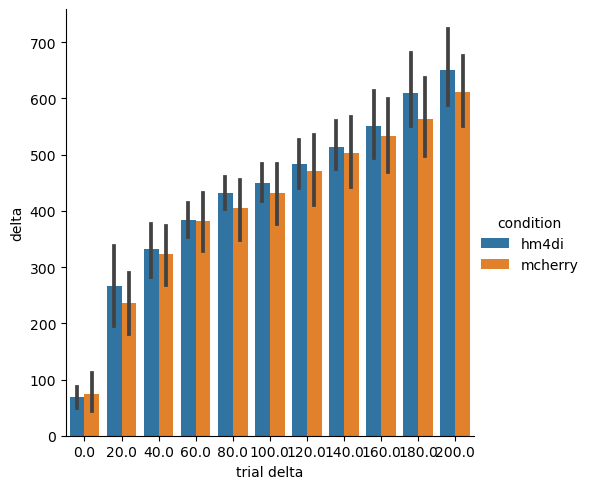

In [32]:
#time since air for nth trial
#mean time to nth trial by condition
time = aa.groupby(["condition","animal","trial no"]).first().groupby(["condition", "animal", "trial delta"])["delta"].mean()
time = time.reset_index()
#start = pd.to_timedelta(0, unit="min")
time["delta"] = time["delta"].astype("timedelta64[m]")

hm4di = (time["condition"] == "hm4di") | (time["condition"] == "mcherry")
cond = (time["delta"] >= 0) & (time["trial delta"] <= 200) & (time["trial delta"] % 20 == 0)
#sns.catplot(data=time[hm4di & cond], x="trial delta", y="delta", hue="condition", kind="violin", split=True, inner="stick")
sns.catplot(data=time[hm4di & cond], x="trial delta", y="delta", hue="condition", kind="bar")

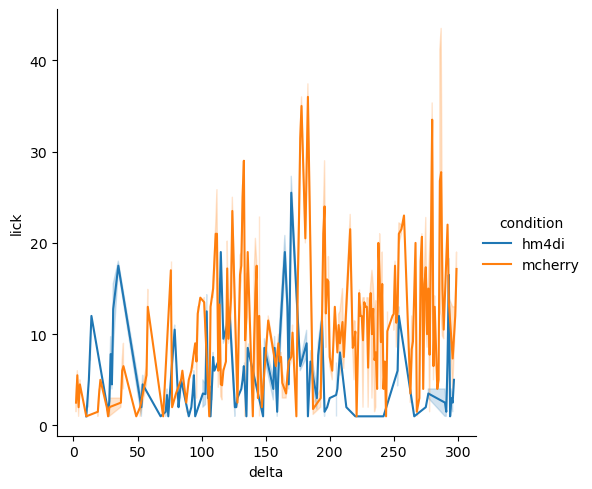

In [33]:
#lick to water immediately after puff; rolling window number of trials, 
start = pd.to_timedelta(0, unit="ms")
end = pd.to_timedelta(200, unit="ms")
postpuff = (aa["delivery delta"] > start) & (aa["delivery delta"] <= end)
gp = aa[postpuff].groupby(["condition", "animal", "trial delta"])

pplf = pd.concat([gp[["lick", "poke"]].sum()/0.2, gp["delta"].first()], axis=1).reset_index()

hm4di = (pplf["condition"] == "hm4di") | (pplf["condition"] == "mcherry")
start = -pd.to_timedelta(0, unit="min")
end = pd.to_timedelta(300, unit="min")

cond = (pplf["delta"] >= start) & (pplf["delta"] <= end)
pplf = pplf[hm4di & cond]
pplf = pplf.set_index("delta")
pplf = pplf.groupby(["condition", "animal"]).rolling(window="20min").count()

pplf = pplf.reset_index()
pplf["delta"] = pplf["delta"].astype("timedelta64[m]")
pplf = pplf.drop(columns="poke")
#pplf = pplf.melt(id_vars=["condition", "animal", "delta"])
pplf
#time since air is turned on vs lick frequency
sns.relplot(data=pplf, x="delta", y="lick",kind="line", hue="condition")


C:\Users\swind\AppData\Local\Temp\ipykernel_25452\1263063210.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plot = plot.groupby(["condition", "animal", "trial type",pd.Grouper(freq=pd.to_timedelta(20, unit="min"))]).mean().reset_index()


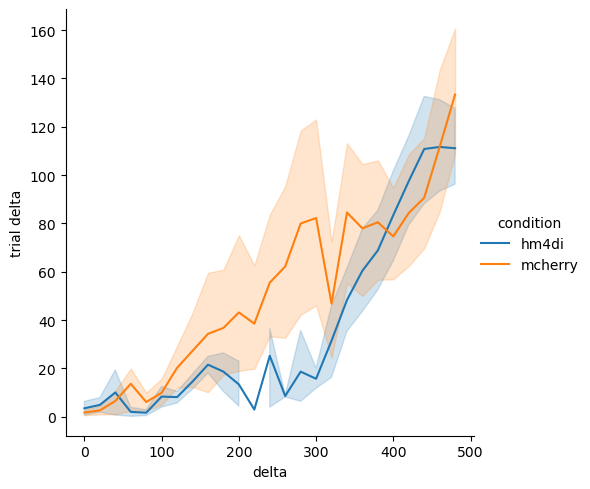

In [34]:
#number of trials over time - mCherry animals start doing trials sooner than hm4di animals
plot = aa

plot = plot.set_index("delta")
plot = plot.groupby(["condition", "animal", "trial type",pd.Grouper(freq=pd.to_timedelta(20, unit="min"))]).mean().reset_index()

start = pd.to_timedelta(0, unit="min")
end = pd.to_timedelta(500, unit="min")
hm4di = (plot["condition"] == "hm4di") | (plot["condition"] == "mcherry")
plot = plot[hm4di & (plot["delta"] >= start) & (plot["delta"] < end)]

plot["delta"] = plot["delta"].astype("timedelta64[m]")
sns.relplot(data=plot, x="delta", y="trial delta", hue="condition", kind="line")

#roll = plot.groupby(["condition", "animal", "trial type"])[["lick", "trial delta"]].rolling(window=10).mean()

C:\Users\swind\AppData\Local\Temp\ipykernel_25452\356226511.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  i = i.groupby(["condition", "animal", "trial type",pd.Grouper(freq=pd.to_timedelta(60, unit="min"))]).mean().reset_index()
C:\Users\swind\AppData\Local\Temp\ipykernel_25452\356226511.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iplot["delta"] = iplot["delta"].astype("timedelta64[m]")


KeyboardInterrupt: 

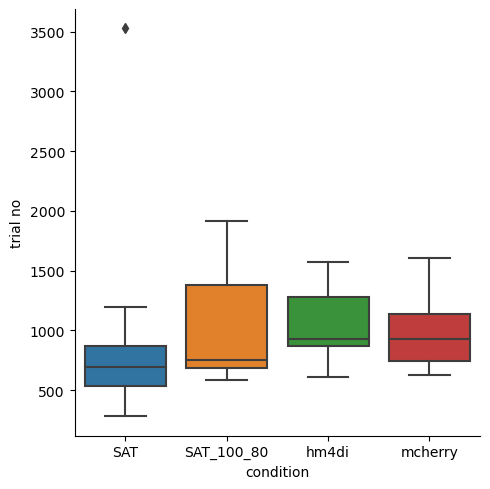

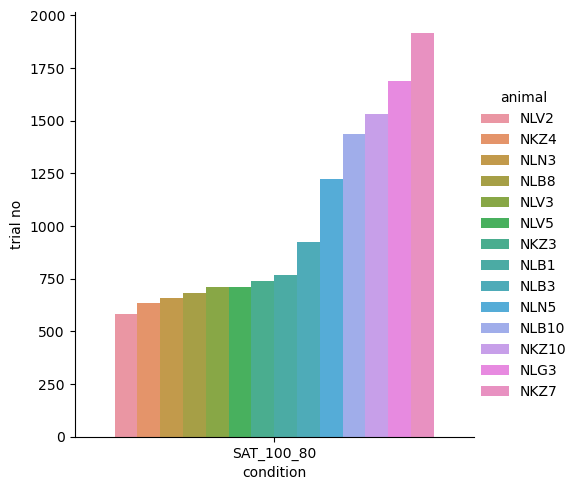

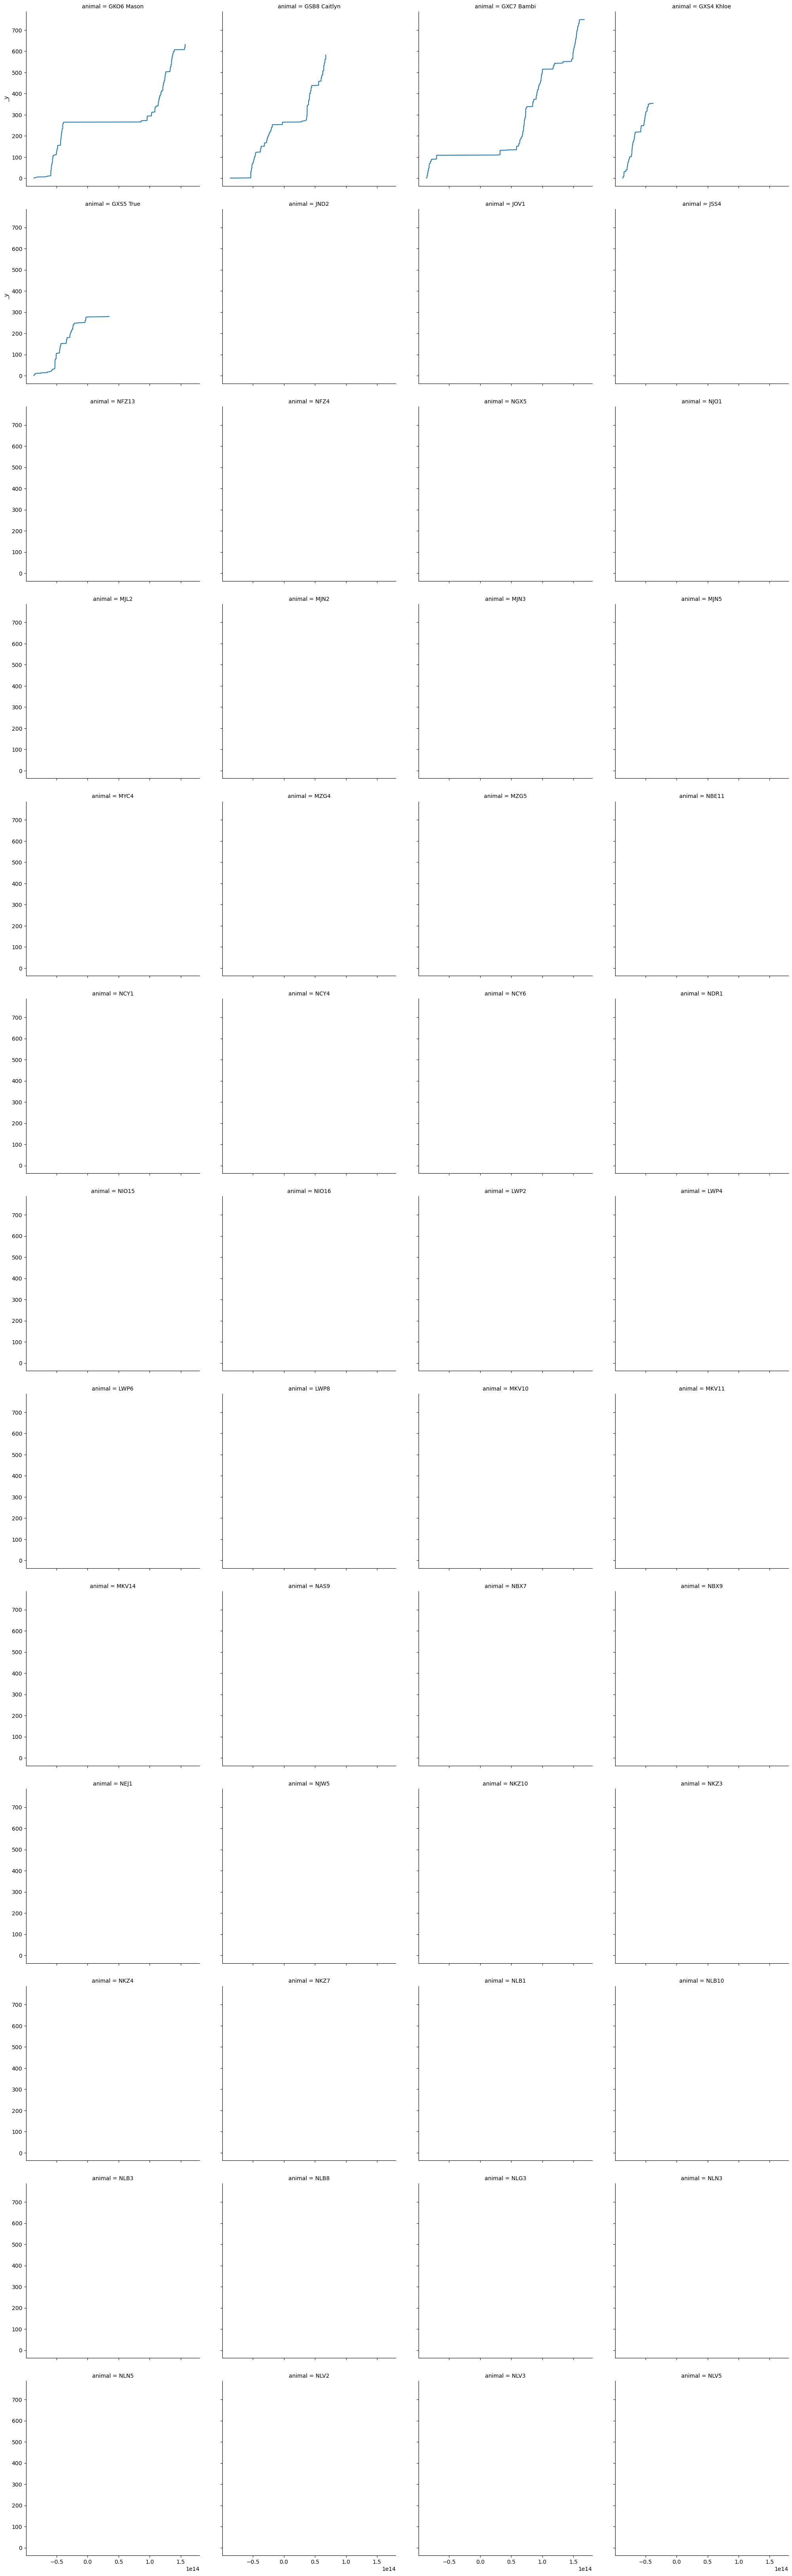

In [35]:
#intertrial interval
i = intervals(aa, ["timestamp", "trial type", "delta", "delivery delta", "trial delta", "lick"])

i = i.set_index("delta")
i["interval"] = i["interval"].astype("timedelta64[s]")
i = i.groupby(["condition", "animal", "trial type",pd.Grouper(freq=pd.to_timedelta(60, unit="min"))]).mean().reset_index()


hm4di = (i["condition"] == "hm4di") | (i["condition"] == "mcherry")
start = pd.to_timedelta(0, unit="min")
end = pd.to_timedelta(500, unit="min")

timecond = (i["delta"] >= start) & (i["delta"] < end)
iplot = i[~hm4di]
iplot["delta"] = iplot["delta"].astype("timedelta64[m]")
#iplot = iplot.melt(id_vars=["condition", "animal", "trial type", "delta"], value_vars=["trial delta", "interval"])
#sns.relplot(data=iplot, x="delta", y="trial no", kind="line", hue="condition", style="condition", markers=True, col="animal", col_wrap=4)
total_trials = aa.groupby(["condition", "animal"]).max()[["trial no", "acc"]].reset_index()
total_trials["acc"] = total_trials["acc"].astype("timedelta64[D]")
#sns.catplot(data=total_trials, x="condition",y="trial no", kind="bar", hue="animal", legend=False)
sns.catplot(data=total_trials, x="condition",y="trial no", kind="box")
sns.catplot(data=total_trials[total_trials["condition"] == "SAT_100_80"].sort_values("trial no"), x="condition",y="trial no", kind="bar", hue="animal")
sns.relplot(data=aa, x="delta", y="trial no", col="animal", col_wrap=4, hue="condition", style="condition", kind="line")
tt = total_trials[["condition", "trial no"]].set_index("condition")
scipy.stats.f_oneway(tt.loc[("SAT")], tt.loc[("SAT_100_80")], tt.loc[("hm4di")], tt.loc[("mcherry")])

In [36]:
plot = aa.groupby(["condition", "animal", "trial no"]).first().reset_index()
plot["delta"] = plot["delta"].astype("timedelta64[m]")
g = sns.relplot(data=plot, x="delta", y="trial no", col="animal", col_wrap=4, hue="condition", style="condition")
for ax in g.axes.flat:
    ax.set_ylim(0, 2000)
    ax.set_xlim(-2880, 1440)

Error in callback <function flush_figures at 0x000002B0719CECA0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
res = scipy.stats.tukey_hsd(tt.loc[("SAT")]["trial no"], tt.loc[("SAT_100_80")]["trial no"], tt.loc[("hm4di")]["trial no"], tt.loc[("mcherry")]["trial no"])
print(res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)   -104.202     0.956  -648.019   439.614
 (0 - 2)   -122.333     0.939  -686.679   442.012
 (0 - 3)    -66.988     0.988  -610.805   476.829
 (1 - 0)    104.202     0.956  -439.614   648.019
 (1 - 2)    -18.131     1.000  -561.948   525.686
 (1 - 3)     37.214     0.998  -485.268   559.697
 (2 - 0)    122.333     0.939  -442.012   686.679
 (2 - 1)     18.131     1.000  -525.686   561.948
 (2 - 3)     55.345     0.993  -488.472   599.162
 (3 - 0)     66.988     0.988  -476.829   610.805
 (3 - 1)    -37.214     0.998  -559.697   485.268
 (3 - 2)    -55.345     0.993  -599.162   488.472



In [ ]:
i = intervals(aa, ["timestamp", "trial type", "delta", "delivery delta", "trial delta", "lick"])

i = i.set_index("delta")
i["interval"] = i["interval"].astype("timedelta64[s]")
i = i.groupby(["condition", "animal", "trial type",pd.Grouper(freq=pd.to_timedelta(60, unit="min"))]).max().reset_index()

hm4di = (i["condition"] == "hm4di") | (i["condition"] == "mcherry")
start = pd.to_timedelta(0, unit="min")
end = pd.to_timedelta(500, unit="min")
timecond = (i["delta"] >= start) & (i["delta"] < end)
i["delta"] = i["delta"].astype("timedelta64[m]")

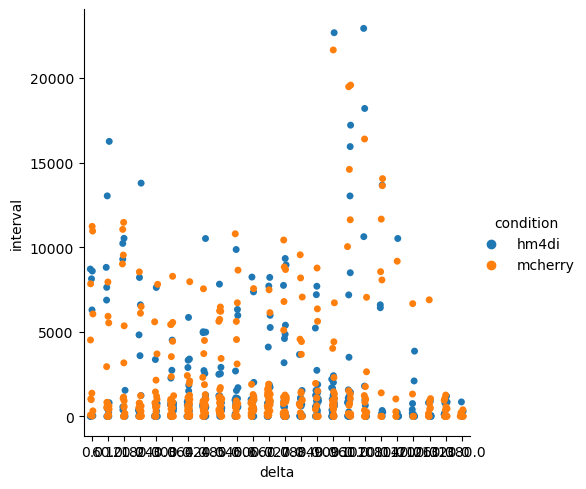

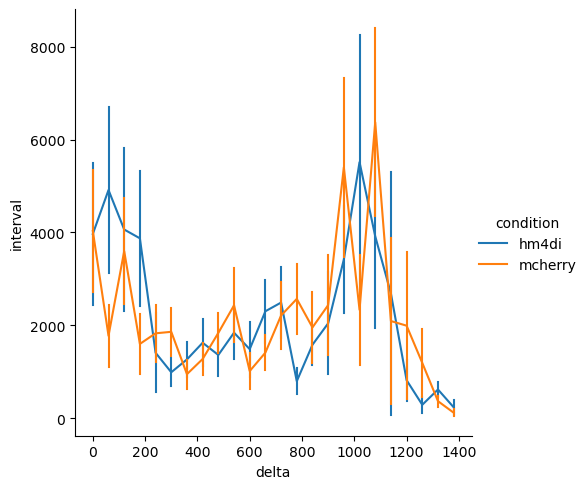

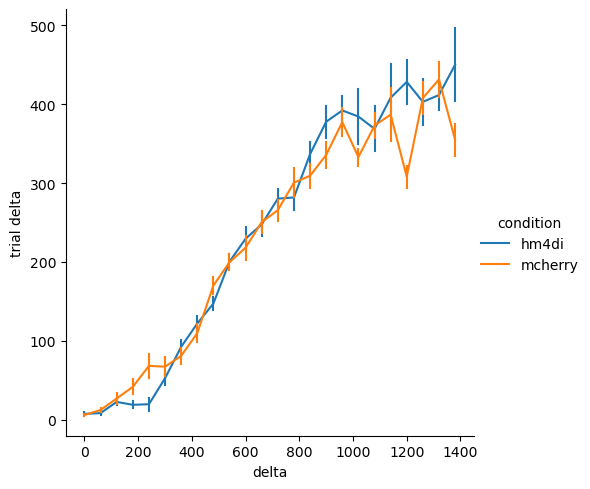

In [ ]:
sns.catplot(data=i[hm4di & timecond], x="delta",y="interval", kind="strip", hue="condition")
sns.relplot(data=i[hm4di & timecond], x="delta",y="interval", kind="line", hue="condition",errorbar="se", err_style="bars")
sns.relplot(data=i[hm4di & timecond], x="delta",y="trial delta", kind="line", hue="condition",errorbar="se", err_style="bars")

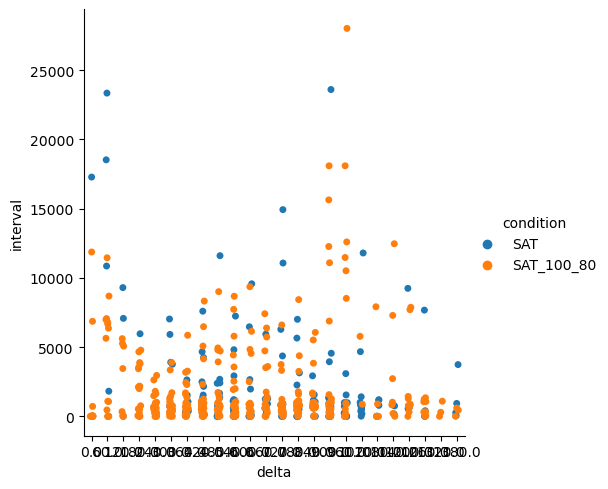

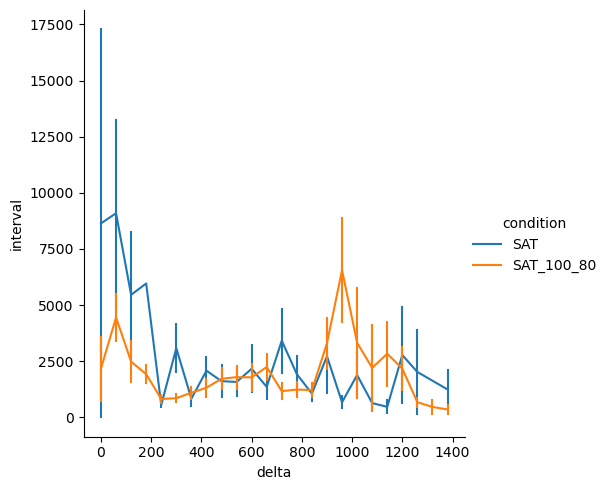

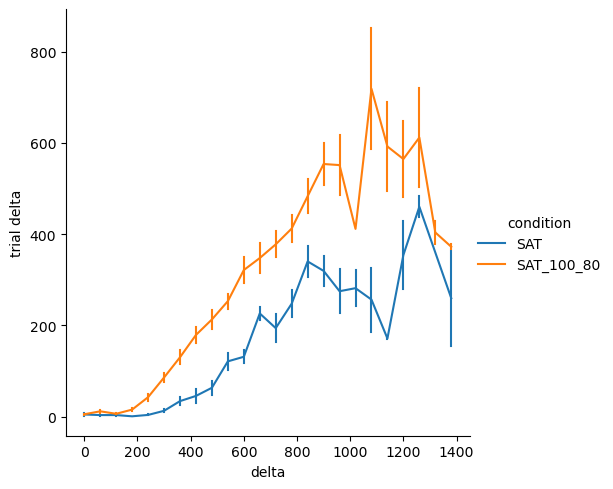

In [ ]:
sns.catplot(data=i[~hm4di & timecond & (i["animal"] != "JOV1")], x="delta",y="interval", kind="strip", hue="condition")
sns.relplot(data=i[~hm4di & timecond & (i["animal"] != "JOV1")], x="delta",y="interval", kind="line", hue="condition",errorbar="se", err_style="bars")
sns.relplot(data=i[~hm4di & timecond & (i["animal"] != "JOV1")], x="delta",y="trial delta", kind="line", hue="condition",errorbar="se", err_style="bars")

### Conclusion


Max (ii) or averaged (num trials) into 60 min bins


hM4Di animals feel the air puff more than mCherry animals – they take longer to start doing trials after the start of SAT and the time between trials is longer after the start of SAT